In [1]:
import numpy as np
from epyt import epanet
import matplotlib.pyplot as plt

from esc.water_usage import TYPICAL_BUILDING_MEAN_WATER_CONSUMPTION_LITER_PER_MINUTE, relative_occupant_water_demand
from esc.electricity_rates import electricity_rate


In [3]:
d = epanet("../networks/BUILDING.inp")

EPANET version 20200 loaded (EPyT version 1.0.2).
Input File BUILDING.inp loaded successfully.



In [4]:
SIMULATION_DURATION_S = 172800
SIMULATION_TIMESTEP_S = 60
N_SIMULATION_STEPS = SIMULATION_DURATION_S / SIMULATION_TIMESTEP_S

d.setTimeSimulationDuration(SIMULATION_DURATION_S) # 48 hour duration
d.setTimeHydraulicStep(SIMULATION_TIMESTEP_S) # Time step every minute
d.setTimePatternStep(SIMULATION_TIMESTEP_S) # Pattern step every minute

In [5]:
# Add time-dependent pattern for occupant demand to the outflow junction
# Sample the demand for every minute of the day
demand_sample_24h = relative_occupant_water_demand(np.arange(N_SIMULATION_STEPS))
d.addPattern("relative_occupant_demand", demand_sample_24h)
d.setNodeJunctionData(1, 0, TYPICAL_BUILDING_MEAN_WATER_CONSUMPTION_LITER_PER_MINUTE, 'relative_occupant_demand')

In [6]:
pump_states = np.load("../data/pump_states.npy")

In [7]:
d.deleteControls()
tankID = 'T1'
pumpID = 'PUMP'

tankIndex = d.getNodeIndex(tankID)
pumpIndex = d.getLinkIndex(pumpID)
tankElevation = d.getNodeElevations(tankIndex)

# Hydraulic analysis STEP-BY-STEP.
d.openHydraulicAnalysis()
d.initializeHydraulicAnalysis(0)

tstep = 1
i = 0
T, P, F, S, E = [], [], [], [], []

# CONTROLS.
tankHead = []
while i < N_SIMULATION_STEPS:

    H = d.getNodeHydraulicHead()
    tankHead.append(H[tankIndex - 1] - tankElevation)

    action = int(pump_states[i][0])
    d.setLinkStatus(pumpIndex, action)
    i += 1

    t = d.runHydraulicAnalysis()

    S.append(d.getLinkStatus(pumpIndex))
    F.append(d.getLinkFlows())
    P.append(d.getNodePressure())
    E.append(d.getLinkEnergy(pumpIndex))
    T.append(t)

    tstep = d.nextHydraulicAnalysisStep()

d.closeHydraulicAnalysis()
print("Hydraulic Analysis completed succesfully.")

Hydraulic Analysis completed succesfully.


Text(0.5, 1.0, 'Water Demand v. Tank Level')

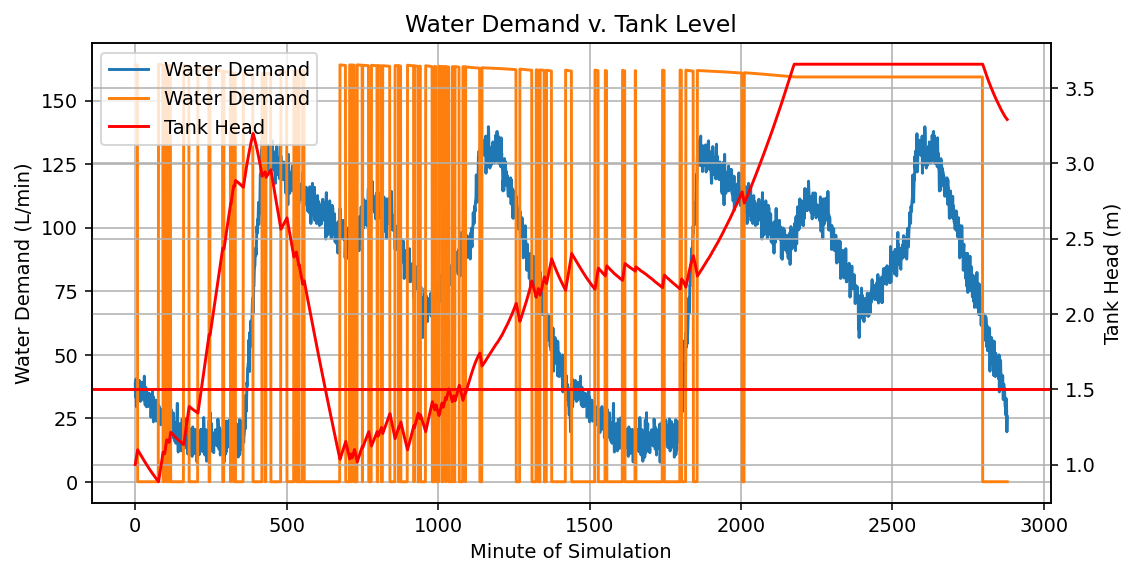

In [10]:
fig, ax1 = plt.subplots()
fig.set_dpi(140)
fig.set_figwidth(8)
fig.set_figheight(4)
ln1 = ax1.plot(F, label="Water Demand")
ax2 = ax1.twinx()
ln2 = ax2.plot(tankHead, label="Tank Head", color="r")
ax2.grid()
ax2.axhline(1.5, color="r")
ax1.grid()
ax1.legend(ln1 + ln2, [l.get_label() for l in ln1 + ln2], loc=2)
ax1.set_xlabel("Minute of Simulation")
ax1.set_ylabel("Water Demand (L/min)")
ax2.set_ylabel("Tank Head (m)")
plt.title("Water Demand v. Tank Level")

Text(0.5, 1.0, 'Pump Energy Cost')

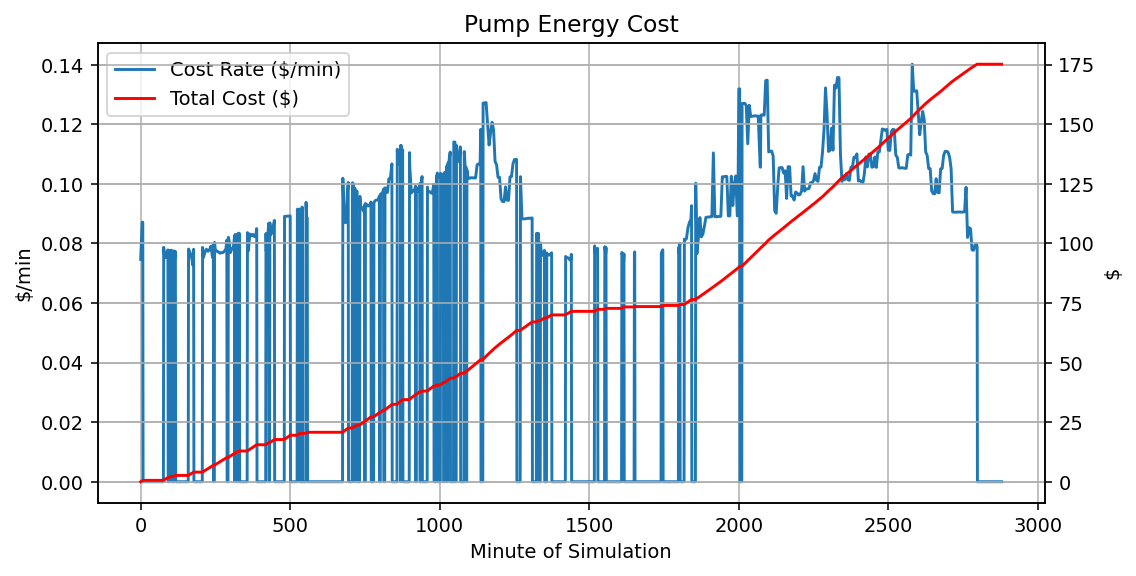

In [12]:
fig, ax1 = plt.subplots()
fig.set_dpi(140)
fig.set_figwidth(8)
fig.set_figheight(4)
ln1 = ax1.plot(E * electricity_rate(np.arange(N_SIMULATION_STEPS)), label="Cost Rate ($/min)")
ax2 = ax1.twinx()
ln2 = ax2.plot(np.cumsum(E * electricity_rate(np.arange(N_SIMULATION_STEPS))), label="Total Cost ($)", color="r")
ax2.grid()
ax1.grid()
ax1.legend(ln1 + ln2, [l.get_label() for l in ln1 + ln2], loc=2)
ax1.set_xlabel("Minute of Simulation")
ax1.set_ylabel("$/min")
ax2.set_ylabel("$")
plt.title("Pump Energy Cost")